In [3]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from natsort import index_natsorted
import seaborn as sns
from natsort import natsorted

sns.set_context("talk")
sns.set_style("whitegrid")

In [5]:
# Adjust to your local path if needed
METRICS_CSV = Path("/Users/danie/repos/alpaca-segmentation/data_postprocessing/BENCHMARK/metrics.csv")
PER_TAPE_CSV = METRICS_CSV.with_name("metrics_per_tape.csv")

assert METRICS_CSV.exists(), f"{METRICS_CSV} not found"

df = pd.read_csv(METRICS_CSV)

# sanity
need_cols = {"model","variant","precision","recall","f1","n_pred","tp","fp","fn"}
missing = need_cols - set(df.columns)
assert not missing, f"metrics.csv missing columns: {missing}"

has_layer = "layer" in df.columns
if not has_layer:
    print("⚠️  'layer' column not found – treating all rows as 'evaluation'")
    df["layer"] = "evaluation"

# sort by (model, variant) naturally
df = (
    df.set_index(["model", "variant"])
      .iloc[index_natsorted(df.index)]  # ← positional indexer, matches iloc
      .reset_index()
)

df.head()

,model,variant,n_gt,n_pred,tp,fp,fn,precision,recall,f1,...,mean_dend_ms,recall_q1,f1_q1,recall_q2,f1_q2,recall_q3,f1_q3,pearson_calls,spearman_calls,layer
0,v1_clipwise_balanced_nph_1,len400_hop050_th10,181,12378,35,12343,146,0.002828,0.193370,0.005574,...,244.200000,0.217391,0.172414,0.178571,0.272109,0.217391,0.246914,-0.507804,-0.465242,evaluation
1,v1_clipwise_balanced_nph_1,len400_hop050_th10,181,586,33,553,148,0.056314,0.182320,0.086050,...,232.696970,0.217391,0.178571,0.160714,0.248276,0.217391,0.253165,0.537441,0.366048,postrf
2,v1_clipwise_balanced_nph_1,len400_hop050_th20,181,11439,48,11391,133,0.004196,0.265193,0.008262,...,226.312500,0.521739,0.338028,0.214286,0.300000,0.260870,0.255319,-0.463788,-0.339627,evaluation
3,v1_clipwise_balanced_nph_1,len400_hop050_th20,181,556,47,509,134,0.084532,0.259669,0.127544,...,226.170213,0.521739,0.342857,0.205357,0.289308,0.260870,0.258065,0.540283,0.392592,postrf
4,v1_clipwise_balanced_nph_1,len400_hop050_th30,181,10752,57,10695,124,0.005301,0.314917,0.010427,...,242.157895,0.521739,0.300000,0.285714,0.378698,0.282609,0.252427,-0.410999,-0.297755,evaluation


In [6]:
def parse_variant_tag(tag: str):
    """Return (seq_len_s, hop_s, threshold_float) from e.g. 'len400_hop050_th80'."""
    m = re.match(r"len(\d+)_hop(\d+)_th(\d+)", str(tag))
    if not m:
        return None, None, None
    seq = int(m[1]) / 1000.0
    hop = int(m[2]) / 1000.0
    th  = int(m[3]) / 100.0
    return seq, hop, th

df[["seq_len_s","hop_s","threshold"]] = df["variant"].apply(lambda t: pd.Series(parse_variant_tag(t)))
df.head()

,model,variant,n_gt,n_pred,tp,fp,fn,precision,recall,f1,...,recall_q2,f1_q2,recall_q3,f1_q3,pearson_calls,spearman_calls,layer,seq_len_s,hop_s,threshold
0,v1_clipwise_balanced_nph_1,len400_hop050_th10,181,12378,35,12343,146,0.002828,0.193370,0.005574,...,0.178571,0.272109,0.217391,0.246914,-0.507804,-0.465242,evaluation,0.4,0.05,0.1
1,v1_clipwise_balanced_nph_1,len400_hop050_th10,181,586,33,553,148,0.056314,0.182320,0.086050,...,0.160714,0.248276,0.217391,0.253165,0.537441,0.366048,postrf,0.4,0.05,0.1
2,v1_clipwise_balanced_nph_1,len400_hop050_th20,181,11439,48,11391,133,0.004196,0.265193,0.008262,...,0.214286,0.300000,0.260870,0.255319,-0.463788,-0.339627,evaluation,0.4,0.05,0.2
3,v1_clipwise_balanced_nph_1,len400_hop050_th20,181,556,47,509,134,0.084532,0.259669,0.127544,...,0.205357,0.289308,0.260870,0.258065,0.540283,0.392592,postrf,0.4,0.05,0.2
4,v1_clipwise_balanced_nph_1,len400_hop050_th30,181,10752,57,10695,124,0.005301,0.314917,0.010427,...,0.285714,0.378698,0.282609,0.252427,-0.410999,-0.297755,evaluation,0.4,0.05,0.3


In [7]:
leader_cols = ["model","variant","precision","recall","f1","mean_dstart_ms","mean_dend_ms","threshold"]
baseline = df[df["layer"]=="evaluation"].copy()
leader = baseline[leader_cols].sort_values("f1", ascending=False)
leader.head(20)

,model,variant,precision,recall,f1,mean_dstart_ms,mean_dend_ms,threshold
34,v2_quality_and_clipwise_balanced_nph_1,len400_hop050_th90,0.024740,0.381215,0.046465,236.797101,236.753623,0.9
52,v3_quality_balanced_nph_1,len400_hop050_th90,0.023373,0.436464,0.044370,234.037975,185.531646,0.9
70,v4_random_nph_1,len400_hop050_th90,0.015294,0.403315,0.029471,244.273973,227.027397,0.9
16,v1_clipwise_balanced_nph_1,len400_hop050_th90,0.014871,0.563536,0.028977,201.627451,121.176471,0.9
50,v3_quality_balanced_nph_1,len400_hop050_th80,0.012430,0.381215,0.024075,276.956522,221.304348,0.8
14,v1_clipwise_balanced_nph_1,len400_hop050_th80,0.011255,0.486188,0.022000,235.159091,158.113636,0.8
32,v2_quality_and_clipwise_balanced_nph_1,len400_hop050_th80,0.011027,0.353591,0.021387,248.609375,255.062500,0.8
12,v1_clipwise_balanced_nph_1,len400_hop050_th70,0.009644,0.453039,0.018885,236.963415,172.939024,0.7
48,v3_quality_balanced_nph_1,len400_hop050_th70,0.008798,0.337017,0.017149,266.868852,238.163934,0.7
10,v1_clipwise_balanced_nph_1,len400_hop050_th60,0.008610,0.436464,0.016888,246.000000,176.518987,0.6


In [8]:
display(df["layer"].value_counts())
models_by_layer = df.groupby(["model","layer"]).size().unstack(fill_value=0)
models_by_layer

layer
evaluation    36
postrf        36
Name: count, dtype: int64

layer,evaluation,postrf
model,,
v1_clipwise_balanced_nph_1,9,9
v2_quality_and_clipwise_balanced_nph_1,9,9
v3_quality_balanced_nph_1,9,9
v4_random_nph_1,9,9


In [9]:
# metrics we want to compare
VALS = [
    "precision","recall","f1",
    "n_pred","tp","fp","fn",
    "mean_dstart_ms","mean_dend_ms",
    "recall_q1","recall_q2","recall_q3"
]

# pivot: one row per (model,variant,seq_len,hop,threshold), columns per layer
piv = df.pivot_table(
    index=["model","variant","seq_len_s","hop_s","threshold"],
    columns="layer",
    values=VALS,
    aggfunc="first"
).sort_index()

# flatten columns ('precision','evaluation') -> 'precision_evaluation'
piv.columns = [f"{m}_{l}" for (m,l) in piv.columns.to_flat_index()]

# compute deltas: postrf - evaluation (only where both exist)
def dcol(name): return (f"{name}_postrf", f"{name}_evaluation")

for m in VALS:
    c_post, c_eval = dcol(m)
    if c_post in piv.columns and c_eval in piv.columns:
        piv[f"delta_{m}"] = piv[c_post] - piv[c_eval]

piv.head()

f1_evaluation  \
model                      variant            seq_len_s hop_s threshold                  
v1_clipwise_balanced_nph_1 len400_hop050_th10 0.4       0.05  0.1             0.005574   
                           len400_hop050_th20 0.4       0.05  0.2             0.008262   
                           len400_hop050_th30 0.4       0.05  0.3             0.010427   
                           len400_hop050_th40 0.4       0.05  0.4             0.012389   
                           len400_hop050_th50 0.4       0.05  0.5             0.014875   

                                                                         f1_postrf  \
model                      variant            seq_len_s hop_s threshold              
v1_clipwise_balanced_nph_1 len400_hop050_th10 0.4       0.05  0.1         0.086050   
                           len400_hop050_th20 0.4       0.05  0.2         0.127544   
                           len400_hop050_th30 0.4       0.05  0.3         0.160350   
                           len400_hop050_th40 0.4       0.05  0.4         0.194357   
                           len400_hop050_th50 0.4       0.05  0.5         0.229617   

                                                                         fn_evaluation  \
model                      variant            seq_len_s hop_s threshold                  
v1_clipwise_balanced_nph_1 len400_hop050_th10 0.4       0.05  0.1                  146   
                           len400_hop050_th20 0.4       0.05  0.2                  133   
                           len400_hop050_th30 0.4       0.05  0.3                  124   
                           len400_hop050_th40 0.4       0.05  0.4                  117   
                           len400_hop050_th50 0.4       0.05  0.5                  108   

                                                                         fn_postrf  \
model                      variant            seq_len_s hop_s threshold              
v1_clipwise_balanced_nph_1 len400_hop050_th10 0.4       0.05  0.1              148   
                           len400_hop050_th20 0.4       0.05  0.2              134   
                           len400_hop050_th30 0.4       0.05  0.3              126   
                           len400_hop050_th40 0.4       0.05  0.4              119   
                           len400_hop050_th50 0.4       0.05  0.5              112   

                                                                         fp_evaluation  \
model                      variant            seq_len_s hop_s threshold                  
v1_clipwise_balanced_nph_1 len400_hop050_th10 0.4       0.05  0.1                12343   
                           len400_hop050_th20 0.4       0.05  0.2                11391   
                           len400_hop050_th30 0.4       0.05  0.3                10695   
                           len400_hop050_th40 0.4       0.05  0.4                10087   
                           len400_hop050_th50 0.4       0.05  0.5                 9561   

                                                                         fp_postrf  \
model                      variant            seq_len_s hop_s threshold              
v1_clipwise_balanced_nph_1 len400_hop050_th10 0.4       0.05  0.1              553   
                           len400_hop050_th20 0.4       0.05  0.2              509   
                           len400_hop050_th30 0.4       0.05  0.3              450   
                           len400_hop050_th40 0.4       0.05  0.4              395   
                           len400_hop050_th50 0.4       0.05  0.5              351   

                                                                         mean_dend_ms_evaluation  \
model                      variant            seq_len_s hop_s threshold                            
v1_clipwise_balanced_nph_1 len400_hop050_th10 0.4       0.05  0.1                     244.200000   
                           len400_hop050_th20 0.4       0.05  0.2      

In [10]:
# keep rows where both layers exist
both = piv.dropna(subset=[c for m in ["precision","recall","f1"] for c in dcol(m)], how="any")

delta_cols = ["delta_f1","delta_precision","delta_recall","delta_n_pred","delta_fp","delta_fn"]
delta_view = both.reset_index().sort_values(["delta_f1","delta_precision"], ascending=False)
delta_view[["model","variant","threshold"] + delta_cols].head(20)

,model,variant,threshold,delta_f1,delta_precision,delta_recall,delta_n_pred,delta_fp,delta_fn
8,v1_clipwise_balanced_nph_1,len400_hop050_th90,0.9,0.357540,0.310887,-0.088398,-6595,-6579,16
7,v1_clipwise_balanced_nph_1,len400_hop050_th80,0.8,0.294633,0.237173,-0.049724,-7501,-7492,9
26,v3_quality_balanced_nph_1,len400_hop050_th90,0.9,0.279955,0.268663,-0.071823,-3154,-3141,13
6,v1_clipwise_balanced_nph_1,len400_hop050_th70,0.7,0.260526,0.199723,-0.033149,-8140,-8134,6
25,v3_quality_balanced_nph_1,len400_hop050_th80,0.8,0.241659,0.217409,-0.066298,-5303,-5291,12
5,v1_clipwise_balanced_nph_1,len400_hop050_th60,0.6,0.234837,0.174347,-0.033149,-8776,-8770,6
4,v1_clipwise_balanced_nph_1,len400_hop050_th50,0.5,0.214742,0.156708,-0.022099,-9214,-9210,4
24,v3_quality_balanced_nph_1,len400_hop050_th70,0.7,0.214477,0.185231,-0.049724,-6665,-6656,9
35,v4_random_nph_1,len400_hop050_th90,0.9,0.208525,0.175981,-0.088398,-4475,-4459,16
23,v3_quality_balanced_nph_1,len400_hop050_th60,0.6,0.201623,0.167854,-0.044199,-7678,-7670,8


In [11]:
summary_by_model = (both.reset_index()
    .groupby("model")[delta_cols]
    .mean()
    .sort_values("delta_f1", ascending=False)
)
summary_by_model.style.format("{:+.3f}")

,delta_f1,delta_precision,delta_recall,delta_n_pred,delta_fp,delta_fn
model,,,,,,
v1_clipwise_balanced_nph_1,+0.210,+0.161,-0.029,-9204.667,-9199.333,+5.333
v3_quality_balanced_nph_1,+0.183,+0.154,-0.044,-7877.778,-7869.889,+7.889
v2_quality_and_clipwise_balanced_nph_1,+0.099,+0.072,-0.038,-9109.667,-9102.778,+6.889
v4_random_nph_1,+0.098,+0.073,-0.031,-11361.778,-11356.111,+5.667


TypeError: functools.partial(<class 'matplotlib.lines.Line2D'>, xdata=[], ydata=[]) got multiple values for keyword argument 'label'

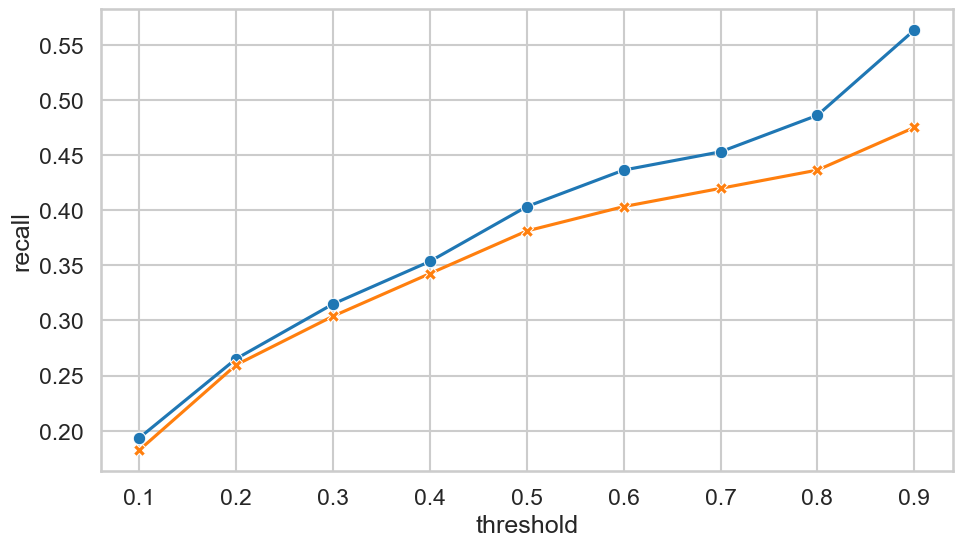

In [12]:
def line_by_threshold(metric: str, title: str, ylim=(0,1)):
    plt.figure(figsize=(11,6))
    for model, sub in df.groupby("model"):
        sub = sub.sort_values("threshold")
        sns.lineplot(
            data=sub,
            x="threshold", y=metric,
            hue="layer", style="layer",
            markers=True, dashes=False,
            legend="brief", label=model
        )
    plt.title(title)
    plt.ylim(*ylim)
    plt.grid(True, linestyle=":")
    plt.show()

line_by_threshold("recall", "Recall over threshold (evaluation vs postrf)")
line_by_threshold("precision", "Precision over threshold (evaluation vs postrf)")
line_by_threshold("f1", "F1 over threshold (evaluation vs postrf)")

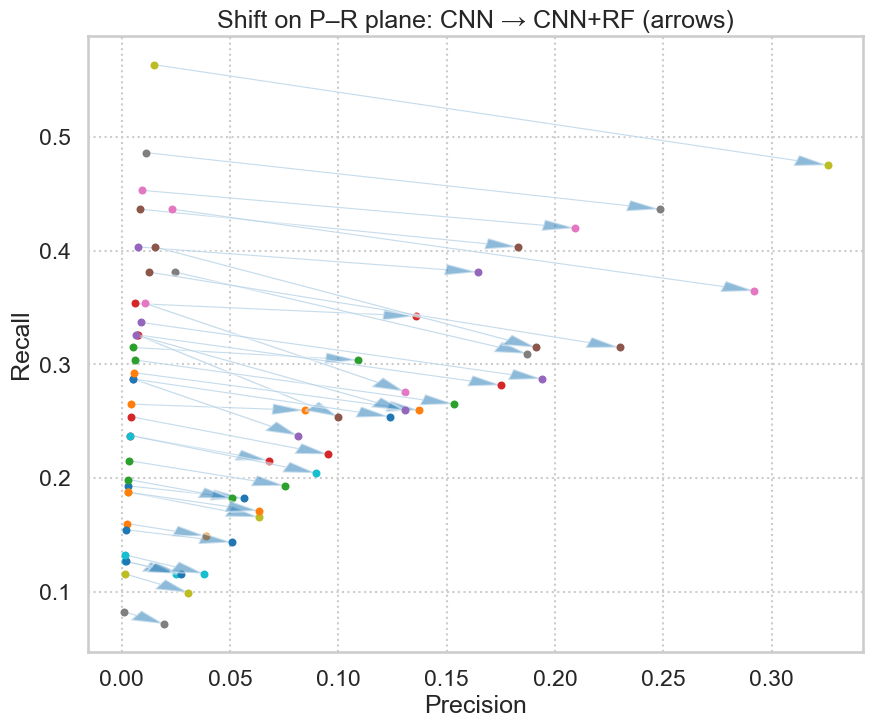

In [13]:
plt.figure(figsize=(10,8))
for (model,variant), sub in df.groupby(["model","variant"]):
    if set(sub["layer"]) >= {"evaluation","postrf"}:
        ev = sub[sub["layer"]=="evaluation"].set_index("threshold")[["precision","recall"]]
        rf = sub[sub["layer"]=="postrf"].set_index("threshold")[["precision","recall"]]
        shared_th = sorted(set(ev.index).intersection(rf.index))
        for th in shared_th:
            x0,y0 = ev.loc[th,"precision"], ev.loc[th,"recall"]
            x1,y1 = rf.loc[th,"precision"], rf.loc[th,"recall"]
            plt.arrow(x0,y0, x1-x0, y1-y0, head_width=0.01, length_includes_head=True, alpha=0.5)
            plt.scatter([x0,x1],[y0,y1], s=18)
plt.xlabel("Precision"); plt.ylabel("Recall")
plt.title("Shift on P–R plane: CNN → CNN+RF (arrows)")
plt.grid(True, linestyle=":")
plt.show()

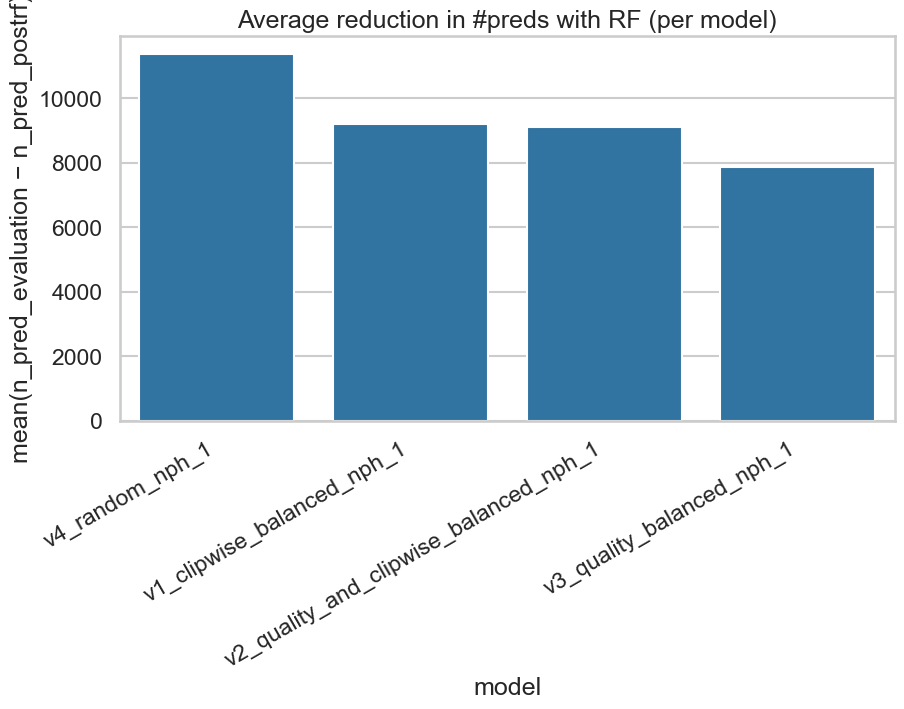

In [14]:
if {"n_pred_evaluation","n_pred_postrf"}.issubset(both.columns):
    tmp = (both.reset_index()
           .assign(reduction=lambda d: d["n_pred_evaluation"] - d["n_pred_postrf"]))
    g = tmp.groupby("model")["reduction"].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,5))
    sns.barplot(x=g.index, y=g.values)
    plt.title("Average reduction in #preds with RF (per model)")
    plt.ylabel("mean(n_pred_evaluation − n_pred_postrf)")
    plt.xticks(rotation=30, ha="right")
    plt.show()
else:
    print("n_pred_evaluation/postrf not both present – skipping.")

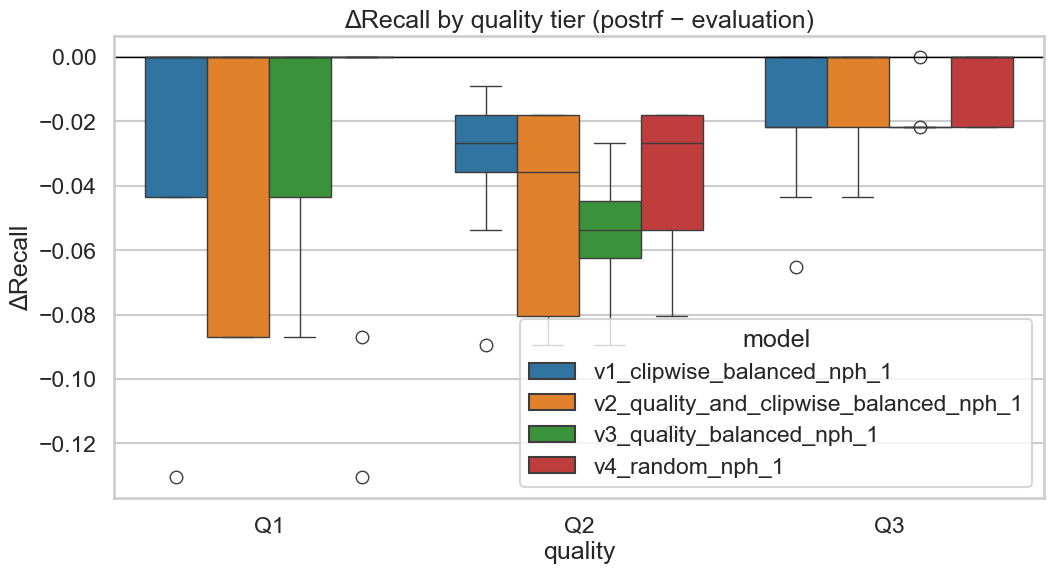

In [15]:
have_q = all(c in both.columns for c in ["delta_recall_q1","delta_recall_q2","delta_recall_q3"])
if have_q:
    cols = ["delta_recall_q1","delta_recall_q2","delta_recall_q3"]
    tmp = both.reset_index()[["model","variant","threshold"] + cols]
    m = tmp.melt(id_vars=["model","variant","threshold"], value_vars=cols,
                 var_name="quality", value_name="delta_recall")
    m["quality"] = m["quality"].str.replace("delta_recall_", "", regex=False).str.upper()
    plt.figure(figsize=(12,6))
    sns.boxplot(data=m, x="quality", y="delta_recall", hue="model")
    plt.axhline(0, color="k", lw=1)
    plt.title("ΔRecall by quality tier (postrf − evaluation)")
    plt.ylabel("ΔRecall")
    plt.show()
else:
    print("Quality-stratified recall columns missing – skipping.")

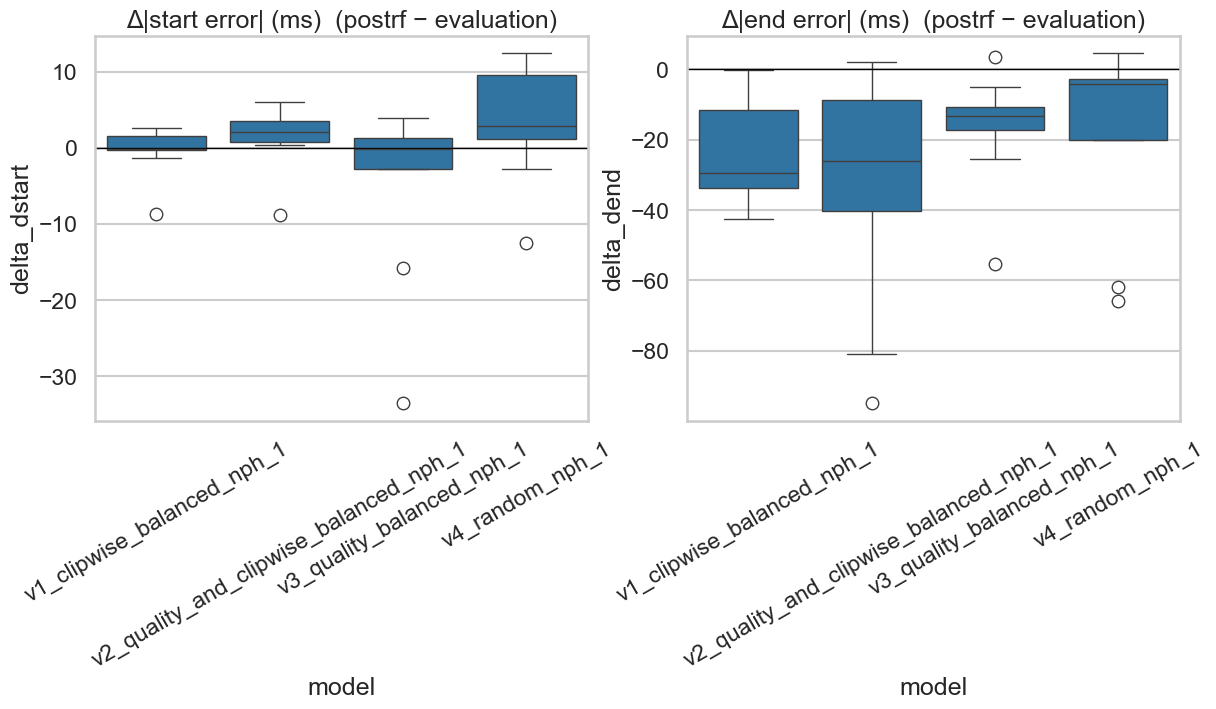

In [16]:
req = {"mean_dstart_ms_evaluation","mean_dstart_ms_postrf","mean_dend_ms_evaluation","mean_dend_ms_postrf"}
if req.issubset(both.columns):
    tmp = (both.reset_index()
           .assign(delta_dstart=lambda d: d["mean_dstart_ms_postrf"] - d["mean_dstart_ms_evaluation"],
                   delta_dend=lambda d: d["mean_dend_ms_postrf"] - d["mean_dend_ms_evaluation"]))
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    sns.boxplot(data=tmp, x="model", y="delta_dstart", ax=ax[0])
    ax[0].axhline(0, color="k", lw=1)
    ax[0].set_title("Δ|start error| (ms)  (postrf − evaluation)")
    ax[0].tick_params(axis="x", rotation=30)
    sns.boxplot(data=tmp, x="model", y="delta_dend", ax=ax[1])
    ax[1].axhline(0, color="k", lw=1)
    ax[1].set_title("Δ|end error| (ms)  (postrf − evaluation)")
    ax[1].tick_params(axis="x", rotation=30)
    plt.show()
else:
    print("Boundary error columns missing – skipping.")

In [17]:
if PER_TAPE_CSV.exists():
    dpt = pd.read_csv(PER_TAPE_CSV)
    if "layer" not in dpt.columns:
        dpt["layer"] = "evaluation"

    # pivot per tape
    base_cols = ["precision","recall","f1","tp","fp","fn","n_pred"]
    pt = dpt.pivot_table(index=["model","variant","tape"], columns="layer", values=base_cols, aggfunc="first")
    pt.columns = [f"{m}_{l}" for (m,l) in pt.columns.to_flat_index()]
    for m in base_cols:
        c_post, c_eval = f"{m}_postrf", f"{m}_evaluation"
        if c_post in pt and c_eval in pt:
            pt[f"delta_{m}"] = pt[c_post] - pt[c_eval]

    # tapes with largest precision gain
    top_tapes = (pt.reset_index()
                 .sort_values("delta_precision", ascending=False)
                 .head(20)
                 [["model","variant","tape","delta_precision","delta_recall","delta_f1","n_pred_evaluation","n_pred_postrf"]])
    display(top_tapes)
else:
    print(f"{PER_TAPE_CSV} not found – skipping per-tape analysis.")


,model,variant,tape,delta_precision,delta_recall,delta_f1,n_pred_evaluation,n_pred_postrf
479,v4_random_nph_1,len400_hop050_th80,7919_20250203.wav,0.996416,0.000000,0.992857,279.0,1.0
493,v4_random_nph_1,len400_hop050_th90,7919_20250203.wav,0.993976,0.000000,0.988024,166.0,1.0
339,v3_quality_balanced_nph_1,len400_hop050_th70,7919_20250203.wav,0.986842,0.000000,0.974026,76.0,1.0
87,v1_clipwise_balanced_nph_1,len400_hop050_th70,7919_20250203.wav,0.984375,0.000000,0.969231,64.0,1.0
353,v3_quality_balanced_nph_1,len400_hop050_th80,7919_20250203.wav,0.984375,0.000000,0.969231,64.0,1.0
101,v1_clipwise_balanced_nph_1,len400_hop050_th80,7919_20250203.wav,0.981481,0.000000,0.963636,54.0,1.0
367,v3_quality_balanced_nph_1,len400_hop050_th90,7919_20250203.wav,0.979592,0.000000,0.960000,49.0,1.0
241,v2_quality_and_clipwise_balanced_nph_1,len400_hop050_th90,7919_20250203.wav,0.975000,0.000000,0.951220,40.0,1.0
377,v3_quality_balanced_nph_1,len400_hop050_th90,x_20250205_2nd_obs.wav,0.972727,-0.400000,0.281159,110.0,1.0
114,v1_clipwise_balanced_nph_1,len400_hop050_th90,4212_20250205.wav,0.667742,0.000000,0.761029,217.0,10.0
